In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import joblib
import matplotlib.pyplot as plt

In [3]:
# Custom Mish activation function
def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

In [4]:
# Register the custom activation
tf.keras.utils.get_custom_objects().update({'mish': tf.keras.layers.Activation(mish)})

In [5]:
# -------------------------------------------------------------------------
# Data Preprocessing
# -------------------------------------------------------------------------
def preprocess_data(file_path, test_size=0.2, random_state=42):
    df = pd.read_csv(file_path)
    y = df['Attack_label']
    X = df.drop(['Attack_label'], axis=1)
    Q1, Q3 = X.quantile(0.25), X.quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((X < (Q1 - 3 * IQR)) | (X > (Q3 + 3 * IQR))).any(axis=1)
    X, y = X[mask], y[mask]
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    joblib.dump(scaler, 'robust_scaler.pkl')
    X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=test_size, random_state=random_state, stratify=y)
    return X_train, X_val, y_train, y_val


In [6]:
# -------------------------------------------------------------------------
# Layer 1: Anomaly Detection
# -------------------------------------------------------------------------
class AdaptiveNIDSLayer1:
    def __init__(self, input_dim, latent_dim=16):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.model = self._build_autoencoder()

    def _build_autoencoder(self):
        inputs = layers.Input(shape=(self.input_dim,))
        x = layers.BatchNormalization()(inputs)
        x = layers.Reshape((-1, 1))(x)

        # Feature extraction via Residual CNN
        conv1 = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
        conv2 = layers.Conv1D(32, 3, activation='relu', padding='same')(conv1)
        # Add residual connection
        res = layers.Conv1D(32, 1, padding='same')(conv1)
        x = layers.Add()([conv2, res])
        x = layers.GlobalAveragePooling1D(name="gap_layer")(x)

        # Latent Representation
        x = layers.Dense(64, activation=mish, kernel_regularizer=regularizers.l1(0.0005))(x)
        x = layers.Dropout(0.3)(x)
        encoded = layers.Dense(self.latent_dim, activation='linear')(x)

        # Decoder
        x = layers.RepeatVector(self.input_dim)(encoded)
        x = layers.LSTM(self.latent_dim * 2, return_sequences=True, recurrent_dropout=0.25)(x)
        decoded = layers.TimeDistributed(layers.Dense(1, activation='linear'))(x)
        decoded = layers.Flatten()(decoded)

        autoencoder = keras.Model(inputs=inputs, outputs=decoded)
        autoencoder.compile(
            optimizer=keras.optimizers.Adam(1e-4), 
            loss='mse'
        )
        return autoencoder

    def train(self, X_train, X_val, epochs=50):
        # Learning rate schedule
        lr_schedule = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
        )
        # Early stopping
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True
        )
        
        history = self.model.fit(
            X_train, X_train, 
            epochs=epochs, 
            batch_size=64, 
            validation_data=(X_val, X_val),
            callbacks=[lr_schedule, early_stopping]
        )
        
        return history

    def detect_anomalies(self, X_data, threshold=0.02):
        reconstructed = self.model.predict(X_data)
        errors = np.mean(np.square(X_data - reconstructed), axis=1)
        return X_data[errors > threshold], np.where(errors > threshold)[0]
        
    def extract_features(self, X_anomalies):
        # Create a feature extractor model using the named gap_layer
        feature_extractor = keras.Model(
            inputs=self.model.input, 
            outputs=self.model.get_layer("gap_layer").output
        )
        return feature_extractor.predict(X_anomalies)


In [17]:
# -------------------------------------------------------------------------
# Feature Engineering
# -------------------------------------------------------------------------
def apply_pca(X_features, variance_threshold=0.95):
    pca = PCA(n_components=variance_threshold)
    X_features_pca = pca.fit_transform(X_features)
    joblib.dump(pca, 'pca_model.pkl')
    print(f"Original features: {X_features.shape[1]}")
    print(f"PCA features: {X_features_pca.shape[1]}")
    print(f"Explained variance: {sum(pca.explained_variance_ratio_):.4f}")
    return X_features_pca, pca

def select_features(X_features, y_labels, n_features=10):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_features, y_labels)
    importances = rf.feature_importances_
    feature_indices = np.argsort(importances)[::-1][:n_features]
    X_features_selected = X_features[:, feature_indices]
    print(f"Original features: {X_features.shape[1]}")
    print(f"Selected features: {X_features_selected.shape[1]}")
    return X_features_selected, feature_indices


In [ ]:
# -------------------------------------------------------------------------
# Feature Preprocessing & Sequence Handling
# -------------------------------------------------------------------------
def create_sequences(data, labels=None, seq_length=10, normalize=True):
    """
    Converts feature data into time-series sequences for Layer 2.
    
    Args:
        data (np.array): 2D feature matrix.
        labels (pd.Series or np.array): Corresponding labels.
        seq_length (int): Number of time steps per sequence.
        normalize (bool): Whether to normalize sequence features.
    
    Returns:
        Tuple of (sequential data, adjusted labels)
    """
    # Ensure data is numpy array
    data = np.array(data)
    
    # Feature normalization
    if normalize:
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data)
        joblib.dump(scaler, 'sequence_scaler.pkl')
    
    sequences = []
    seq_labels = []
    
    # Create sequences
    for i in range(len(data) - seq_length + 1):
        seq = data[i:i + seq_length]
        sequences.append(seq)
        
        if labels is not None:
            # Use the label of the last timestep in the sequence
            seq_labels.append(labels[i + seq_length - 1])
    
    # Convert to numpy arrays
    sequences = np.array(sequences)
    
    if labels is not None:
        labels = np.array(labels)
        seq_labels = np.array(seq_labels)
        return sequences, seq_labels
    else:
        return sequences

def balance_sequences_with_smote(X_sequences, y_sequences):
    """
    Balance sequence data using SMOTE.
    
    Args:
        X_sequences: 3D sequence data
        y_sequences: Target labels
        
    Returns:
        Balanced sequences and labels
    """
    # Ensure y_sequences is integer type
    y_sequences = y_sequences.astype(int)
    
    # Reshape to 2D for SMOTE
    original_shape = X_sequences.shape
    X_seq_2d = X_sequences.reshape(X_sequences.shape[0], -1)
    
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_seq_balanced, y_seq_balanced = smote.fit_resample(X_seq_2d, y_sequences)
    
    # Reshape back to 3D
    X_seq_balanced = X_seq_balanced.reshape(-1, original_shape[1], original_shape[2])
    
    print(f"Original class distribution: {np.bincount(y_sequences)}")
    print(f"Balanced class distribution: {np.bincount(y_seq_balanced)}")
    
    return X_seq_balanced, y_seq_balanced


In [ ]:
# -------------------------------------------------------------------------
# Teacher Model for Knowledge Distillation
# -------------------------------------------------------------------------
class TeacherModel:
    def __init__(self, input_dim, num_classes, seq_length=10):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.seq_length = seq_length
        self.model = self._build_teacher_model()

    def _build_teacher_model(self):
        """
        Build a larger, more complex model to serve as the teacher.
        """
        inputs = layers.Input(shape=(self.seq_length, self.input_dim))
        
        # Enhanced CNN blocks
        x = layers.Conv1D(64, kernel_size=3, padding='same')(inputs)
        x = layers.LayerNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.SpatialDropout1D(0.3)(x)
        
        # 2nd CNN block with residual connection
        conv2 = layers.Conv1D(128, kernel_size=3, padding='same')(x)
        conv2 = layers.LayerNormalization()(conv2)
        conv2 = layers.Activation('relu')(conv2)
        
        # Residual connection
        res = layers.Conv1D(128, kernel_size=1, padding='same')(x)
        x = layers.Add()([conv2, res])
        x = layers.SpatialDropout1D(0.3)(x)
        
        # Enhanced BiLSTM
        x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, recurrent_dropout=0.3))(x)
        
        # Attention mechanism
        attention = layers.Dense(1, activation='tanh')(x)
        attention = layers.Flatten()(attention)
        attention = layers.Softmax()(attention)
        attention = layers.RepeatVector(128)(attention)  # 128 = 64*2 (BiLSTM output dim)
        attention = layers.Permute([2, 1])(attention)
        
        # Apply attention
        x = layers.Multiply()([x, attention])
        x = layers.GlobalMaxPooling1D()(x)
        
        # Dense layers
        x = layers.Dense(128, activation='relu')(x)
        x = layers.LayerNormalization()(x)
        x = layers.Dropout(0.4)(x)
        
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)

        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer=keras.optimizers.Adam(1e-3), 
            loss='sparse_categorical_crossentropy', 
            metrics=['accuracy']
        )
        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
        """
        Train the teacher model with adaptive learning rate.
        """
        # Learning rate schedule with warmup and cosine decay
        initial_lr = 1e-3
        warmup_epochs = 5
        
        def lr_schedule(epoch):
            if epoch < warmup_epochs:
                return initial_lr * ((epoch + 1) / warmup_epochs)
            else:
                decay_epochs = epochs - warmup_epochs
                return initial_lr * 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / decay_epochs))
        
        lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
        
        # F1 score callback for early stopping
        class F1ScoreCallback(keras.callbacks.Callback):
            def __init__(self, validation_data, patience=5):
                super(F1ScoreCallback, self).__init__()
                self.X_val, self.y_val = validation_data
                self.patience = patience
                self.best_f1 = 0
                self.wait = 0
                self.best_weights = None
                
            def on_epoch_end(self, epoch, logs={}):
                y_pred = np.argmax(self.model.predict(self.X_val), axis=1)
                f1 = f1_score(self.y_val, y_pred, average='weighted')
                print(f" - val_f1: {f1:.4f}")
                
                if f1 > self.best_f1:
                    self.best_f1 = f1
                    self.wait = 0
                    self.best_weights = self.model.get_weights()
                else:
                    self.wait += 1
                    if self.wait >= self.patience:
                        self.model.stop_training = True
                        print(f"\nRestoring best weights with F1 score: {self.best_f1:.4f}")
                        self.model.set_weights(self.best_weights)
        
        f1_callback = F1ScoreCallback(validation_data=(X_val, y_val))
        
        # Train the model
        history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            callbacks=[lr_scheduler, f1_callback]
        )
        
        return history


In [10]:
# -------------------------------------------------------------------------
# Focal Loss for Imbalanced Classes
# -------------------------------------------------------------------------
def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss implementation for class imbalance.
    Focuses model training on hard-to-classify examples.
    
    Args:
        gamma: Focusing parameter that reduces the loss contribution from easy examples
        alpha: Class weight factor for imbalance
        
    Returns:
        Focal loss function compatible with Keras
    """
    def focal_loss_fixed(y_true, y_pred):
        # Convert y_true to integers
        y_true = tf.cast(y_true, tf.int32)
        
        # Get logits (predictions before softmax)
        if y_pred.shape[-1] > 1:
            # Convert probabilities to logits
            epsilon = tf.keras.backend.epsilon()
            y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
            logits = tf.math.log(y_pred)
        else:
            logits = y_pred
            
        # Compute cross entropy loss
        ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=logits)
        
        # Compute modulating factor
        pt = tf.exp(-ce)
        
        # Apply focal loss formula: alpha * (1-pt)^gamma * ce
        loss = alpha * tf.pow(1-pt, gamma) * ce
        
        return tf.reduce_mean(loss)
    
    return focal_loss_fixed


In [11]:
# -------------------------------------------------------------------------
# Layer 2: Attack Classification with Attention Mechanism
# -------------------------------------------------------------------------
class AdaptiveNIDSLayer2:
    def __init__(self, input_dim, num_classes, seq_length=10):
        """
        Initializes Layer 2 for attack classification using improved CNN-BiLSTM with attention.
        
        Args:
            input_dim (int): Number of input features per time step.
            num_classes (int): Number of attack classes.
            seq_length (int): Number of time steps in sequence.
        """
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.seq_length = seq_length
        self.model = self._build_model()

    def _build_model(self):
        """
        Builds the improved CNN-BiLSTM classification model with attention.
        """
        inputs = layers.Input(shape=(self.seq_length, self.input_dim))
        
        # First CNN block with residual connection
        x = layers.Conv1D(32, kernel_size=3, padding='same')(inputs)
        x = layers.LayerNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.SpatialDropout1D(0.2)(x)
        
        # Second CNN block with residual connection
        conv2 = layers.Conv1D(64, kernel_size=3, padding='same')(x)
        conv2 = layers.LayerNormalization()(conv2)
        conv2 = layers.Activation('relu')(conv2)
        
        # Residual connection
        res = layers.Conv1D(64, kernel_size=1, padding='same')(x)
        x = layers.Add()([conv2, res])
        x = layers.SpatialDropout1D(0.2)(x)
        
        # BiLSTM layer
        lstm_units = 32
        x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True, 
                                           recurrent_dropout=0.2))(x)
                                           
        # Attention mechanism
        attention = layers.Dense(1, activation='tanh')(x)
        attention = layers.Flatten()(attention)
        attention = layers.Softmax()(attention)
        attention = layers.RepeatVector(lstm_units * 2)(attention)  # BiLSTM doubles the units
        attention = layers.Permute([2, 1])(attention)
        
        # Apply attention weights
        x = layers.Multiply()([x, attention])
        x = layers.GlobalMaxPooling1D()(x)
        
        # Fully Connected Layers
        x = layers.Dense(48, activation='relu')(x)
        x = layers.LayerNormalization()(x)
        x = layers.Dropout(0.3)(x)
        
        # Output Layer
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)

        # Compile Model with focal loss for class imbalance
        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer=keras.optimizers.Adam(1e-3), 
            loss=focal_loss(gamma=2.0, alpha=0.25), 
            metrics=['accuracy']
        )
        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
        """
        Trains the Layer 2 model with:
        - Adaptive learning rate schedule
        - F1-score-based early stopping
        """
        # Learning rate schedule with warmup and cosine decay
        initial_lr = 1e-3
        warmup_epochs = 5
        
        def lr_schedule(epoch):
            if epoch < warmup_epochs:
                return initial_lr * ((epoch + 1) / warmup_epochs)
            else:
                decay_epochs = epochs - warmup_epochs
                return initial_lr * 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / decay_epochs))
        
        lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
        
        # Custom F1-score callback for early stopping
        class F1ScoreCallback(keras.callbacks.Callback):
            def __init__(self, validation_data, patience=5):
                super(F1ScoreCallback, self).__init__()
                self.X_val, self.y_val = validation_data
                self.patience = patience
                self.best_f1 = 0
                self.wait = 0
                self.best_weights = None
                
            def on_epoch_end(self, epoch, logs={}):
                # Get predictions
                y_pred = np.argmax(self.model.predict(self.X_val), axis=1)
                # Calculate F1 score
                f1 = f1_score(self.y_val, y_pred, average='weighted')
                print(f" - val_f1: {f1:.4f}")
                
                if f1 > self.best_f1:
                    self.best_f1 = f1
                    self.wait = 0
                    self.best_weights = self.model.get_weights()
                else:
                    self.wait += 1
                    if self.wait >= self.patience:
                        self.model.stop_training = True
                        print(f"\nRestoring best weights with F1 score: {self.best_f1:.4f}")
                        self.model.set_weights(self.best_weights)
        
        f1_callback = F1ScoreCallback(validation_data=(X_val, y_val))
        
        # Train the model
        history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            callbacks=[lr_scheduler, f1_callback]
        )
        
        return history

    def evaluate_model(self, X_test, y_test):
        """
        Evaluates the model and generates detailed performance metrics.
        """
        # Get predictions
        y_pred = np.argmax(self.model.predict(X_test), axis=1)
        
        # Generate classification report
        report = classification_report(y_test, y_pred, output_dict=True)
        
        # Generate confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Calculate detection rate and false positive rate
        detection_rate = {}
        false_positive_rate = {}
        
        for class_idx in range(self.num_classes):
            true_positives = cm[class_idx, class_idx]
            false_negatives = np.sum(cm[class_idx, :]) - true_positives
            false_positives = np.sum(cm[:, class_idx]) - true_positives
            true_negatives = np.sum(cm) - true_positives - false_negatives - false_positives
            
            detection_rate[class_idx] = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
            false_positive_rate[class_idx] = false_positives / (false_positives + true_negatives) if (false_positives + true_negatives) > 0 else 0
        
        # Return detailed evaluation results
        return {
            'classification_report': report,
            'confusion_matrix': cm,
            'detection_rate': detection_rate,
            'false_positive_rate': false_positive_rate
        }

    def plot_training_history(self, history):
        """
        Visualizes training loss and accuracy curves.
        """
        plt.figure(figsize=(12, 5))
        
        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('training_history.png')
        plt.show()


In [ ]:
# -------------------------------------------------------------------------
# Knowledge Distillation with Dynamic Temperature
# -------------------------------------------------------------------------
def knowledge_distillation(teacher_model, student_model, X_train, y_train, X_val, y_val, 
                          initial_temp=5.0, final_temp=1.0, alpha=0.7, epochs=50, batch_size=32):
    """
    Implements enhanced knowledge distillation with:
    - Dynamic temperature adjustment
    - Balanced KL divergence and cross-entropy loss
    - Validation-based early stopping
    
    Args:
        teacher_model: Pre-trained teacher model
        student_model: Student model to be trained
        X_train: Training data features
        y_train: Training data labels
        X_val: Validation data features
        y_val: Validation data labels
        initial_temp: Initial temperature for softmax
        final_temp: Final temperature for softmax
        alpha: Weight balance between hard loss and soft loss
        epochs: Number of training epochs
        batch_size: Batch size for training
    """
    # Ensure y_train and y_val are NumPy arrays
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    
    # Ensure labels are integers for sparse categorical crossentropy
    if len(y_train.shape) > 1 and y_train.shape[1] > 1:
        y_train = np.argmax(y_train, axis=1)
    if len(y_val.shape) > 1 and y_val.shape[1] > 1:
        y_val = np.argmax(y_val, axis=1)
    
    # Get number of classes
    num_classes = student_model.output_shape[-1]
    if isinstance(num_classes, tf.TensorShape):
        num_classes = num_classes.as_list()[-1]
    
    # Create a custom model for distillation
    class DistillationModel(keras.Model):
        def __init__(self, student_model, teacher_model):
            super(DistillationModel, self).__init__()
            self.student_model = student_model
            self.teacher_model = teacher_model
            self.teacher_model.trainable = False  # Freeze teacher weights
        
        def compile(self, optimizer, metrics):
            super(DistillationModel, self).compile(optimizer=optimizer, metrics=metrics)
            self.temperature = tf.Variable(initial_temp, trainable=False)
        
        def train_step(self, data):
            x, y = data
            
            # Forward pass through teacher model
            teacher_logits = self.teacher_model(x, training=False)
            
            # Calculate temperature-scaled probabilities
            current_temp = self.temperature
            teacher_probs = tf.nn.softmax(teacher_logits / current_temp)
            
            with tf.GradientTape() as tape:
                # Forward pass through student model
                student_logits = self.student_model(x, training=True)
                student_probs = tf.nn.softmax(student_logits / current_temp)
                
                # Calculate hard loss (student predictions vs true labels)
                hard_loss = tf.keras.losses.sparse_categorical_crossentropy(y, student_logits)
                
                # Calculate soft loss (KL divergence between teacher and student)
                soft_loss = tf.keras.losses.kullback_leibler_divergence(teacher_probs, student_probs)
                
                # Total loss with dynamic temperature scaling
                total_loss = (1 - alpha) * hard_loss + alpha * soft_loss * (current_temp ** 2)
                
            # Get gradients and update student model
            gradients = tape.gradient(total_loss, self.student_model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.student_model.trainable_variables))
            
            # Update metrics
            self.compiled_metrics.update_state(y, student_logits)
            
            # Return a dict mapping metric names to current values
            results = {m.name: m.result() for m in self.metrics}
            results.update({"hard_loss": tf.reduce_mean(hard_loss), 
                           "soft_loss": tf.reduce_mean(soft_loss),
                           "total_loss": tf.reduce_mean(total_loss),
                           "temperature": current_temp})
            return results
    
    # Create and compile the distillation model
    distillation_model = DistillationModel(student_model, teacher_model)
    distillation_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )
    
    # Create callbacks for distillation
    class TemperatureScheduler(keras.callbacks.Callback):
        def __init__(self, initial_temp, final_temp, epochs):
            super(TemperatureScheduler, self).__init__()
            self.initial_temp = initial_temp
            self.final_temp = final_temp
            self.epochs = epochs
        
        def on_epoch_begin(self, epoch, logs=None):
            # Linear temperature decay
            temp = self.initial_temp - (self.initial_temp - self.final_temp) * epoch / self.epochs
            self.model.temperature.assign(max(temp, self.final_temp))
    
    # Create F1 score callback for early stopping
    class F1ScoreCallback(keras.callbacks.Callback):
        def __init__(self, X_val, y_val, patience=5):
            super(F1ScoreCallback, self).__init__()
            self.X_val = X_val
            self.y_val = y_val
            self.patience = patience
            self.best_f1 = 0
            self.wait = 0
            self.best_weights = None
        
        def on_epoch_end(self, epoch, logs=None):
            # Get predictions from student model
            student_predictions = self.model.student_model.predict(self.X_val)
            y_pred = np.argmax(student_predictions, axis=1)
            
            # Calculate F1 score
            f1 = f1_score(self.y_val, y_pred, average='weighted')
            print(f" - val_f1: {f1:.4f}")
            
            # Check if F1 score improved
            if f1 > self.best_f1:
                self.best_f1 = f1
                self.wait = 0
                # Save best weights
                self.best_weights = self.model.student_model.get_weights()
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    # Restore best weights and stop training
                    self.model.student_model.set_weights(self.best_weights)
                    self.model.stop_training = True
                    print(f"\nEarly stopping at epoch {epoch+1}. Best val_f1: {self.best_f1:.4f}")
    
    # Create callbacks
    callbacks = [
        TemperatureScheduler(initial_temp, final_temp, epochs),
        F1ScoreCallback(X_val, y_val, patience=5)
    ]
    
    # Train the distillation model
    history = distillation_model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    # Return the trained student model and training history
    return distillation_model.student_model, history


In [13]:
# -------------------------------------------------------------------------
# Model Evaluation and Visualization
# -------------------------------------------------------------------------
def evaluate_model_comprehensive(model, X_test, y_test, class_names=None):
    """
    Conducts comprehensive evaluation of model performance.
    
    Args:
        model: Trained classification model
        X_test: Test features
        y_test: Test labels
        class_names: List of class names (optional)
        
    Returns:
        Dictionary of evaluation metrics
    """
    # Get predictions
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Calculate metrics
    accuracy = np.mean(y_pred == y_test)
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate per-class metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Detection rates and false positive rates
    num_classes = len(np.unique(y_test))
    dr = np.zeros(num_classes)
    fpr = np.zeros(num_classes)
    
    for i in range(num_classes):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - tp - fn - fp
        
        dr[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr[i] = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    # Calculate aggregate metrics
    result = {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report,
        'detection_rates': dr,
        'false_positive_rates': fpr,
        'macro_avg_detection_rate': np.mean(dr),
        'macro_avg_false_positive_rate': np.mean(fpr),
        'weighted_f1': f1_score(y_test, y_pred, average='weighted')
    }
    
    return result

def visualize_model_performance(evaluation_results, class_names=None):
    """
    Visualizes model performance metrics.
    
    Args:
        evaluation_results: Dictionary of evaluation metrics
        class_names: List of class names (optional)
    """
    cm = evaluation_results['confusion_matrix']
    report = evaluation_results['classification_report']
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)
    
    # Add text annotations
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    # Plot detection rates and false positive rates
    plt.figure(figsize=(10, 6))
    x = np.arange(len(evaluation_results['detection_rates']))
    width = 0.35
    
    plt.bar(x - width/2, evaluation_results['detection_rates'], width, label='Detection Rate')
    plt.bar(x + width/2, evaluation_results['false_positive_rates'], width, label='False Positive Rate')
    
    plt.ylabel('Rate')
    plt.title('Detection Rates and False Positive Rates by Class')
    
    if class_names is not None:
        plt.xticks(x, class_names, rotation=45)
    
    plt.legend()
    plt.tight_layout()
    plt.savefig('detection_rates.png')
    plt.show()


In [14]:
# -------------------------------------------------------------------------
# Hyperparameter Optimization
# -------------------------------------------------------------------------
def hyperparameter_optimization(X_train, y_train, X_val, y_val, seq_length, input_dim, num_classes):
    """
    Performs hyperparameter optimization for the NIDS model.
    
    Args:
        X_train: Training features
        y_train: Training labels
        X_val: Validation features
        y_val: Validation labels
        seq_length: Sequence length
        input_dim: Input dimension
        num_classes: Number of classes
        
    Returns:
        Best hyperparameters and best model
    """
    # Define hyperparameter grid
    param_grid = {
        'learning_rate': [0.001, 0.0005, 0.0001],
        'dropout_rate': [0.2, 0.3, 0.4],
        'lstm_units': [16, 32, 64],
        'conv_filters': [32, 64, 128]
    }
    
    # Initialize tracking variables
    best_val_f1 = 0
    best_params = None
    best_model = None
    
    # Iterate through parameter combinations
    for params in ParameterGrid(param_grid):
        print(f"Trying parameters: {params}")
        
        # Create and compile model
        model = keras.Sequential([
            layers.Input(shape=(seq_length, input_dim)),
            layers.Conv1D(params['conv_filters'], kernel_size=3, padding='same', activation='relu'),
            layers.SpatialDropout1D(params['dropout_rate']),
            layers.Bidirectional(layers.LSTM(params['lstm_units'], return_sequences=True)),
            layers.GlobalMaxPooling1D(),
            layers.Dense(48, activation='relu'),
            layers.Dropout(params['dropout_rate']),
            layers.Dense(num_classes, activation='softmax')
        ])
        
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=params['learning_rate']),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Train model
        history = model.fit(
            X_train, y_train,
            epochs=15,  # Reduced epochs for faster search
            batch_size=64,
            validation_data=(X_val, y_val),
            verbose=0
        )
        
        # Evaluate model
        y_pred = np.argmax(model.predict(X_val), axis=1)
        val_f1 = f1_score(y_val, y_pred, average='weighted')
        
        print(f"Validation F1 score: {val_f1:.4f}")
        
        # Check if best so far
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_params = params
            best_model = model
    
    print(f"Best parameters: {best_params}")
    print(f"Best validation F1 score: {best_val_f1:.4f}")
    
    return best_params, best_model


In [15]:
# -------------------------------------------------------------------------
# Main Execution
# -------------------------------------------------------------------------
def main():
    # Load and preprocess data
    file_path = "/Users/siddhantgond/Desktop/6THSEM/Project_Elective/Adaptive-Network-Intrusion-Detection-System/Implementaiton/training_dataset.csv"
    X_train, X_val, y_train, y_val = preprocess_data(file_path)
    
    # Layer 1: Anomaly Detection
    anomaly_detector = AdaptiveNIDSLayer1(input_dim=X_train.shape[1], latent_dim=16)
    history = anomaly_detector.train(X_train, X_val, epochs=50)
    
    # Process training data for Layer 2
    X_anomalies, indices = anomaly_detector.detect_anomalies(X_train, threshold=0.02)
    y_anomalies = y_train.iloc[indices].values.astype(int)
    X_features = anomaly_detector.extract_features(X_anomalies)
    
    # Apply PCA and feature selection
    X_pca, pca = apply_pca(X_features)
    X_selected, feature_indices = select_features(X_pca, y_anomalies, n_features=10)
    joblib.dump(feature_indices, 'feature_indices.pkl')  # Save feature indices
    
    # Create sequences
    seq_length = 10
    X_sequences, y_sequences = create_sequences(X_selected, y_anomalies, seq_length=seq_length)
    X_balanced, y_balanced = balance_sequences_with_smote(X_sequences, y_sequences)
    
    # Process validation data for Layer 2
    X_val_anomalies, val_indices = anomaly_detector.detect_anomalies(X_val, threshold=0.02)
    y_val_anomalies = y_val.iloc[val_indices].values.astype(int)
    X_val_features = anomaly_detector.extract_features(X_val_anomalies)
    X_val_pca = pca.transform(X_val_features)
    X_val_selected = X_val_pca[:, feature_indices]  # Now using saved feature indices
    X_val_sequences, y_val_sequences = create_sequences(X_val_selected, y_val_anomalies, seq_length=seq_length)
    
    # Layer 2: Classification
    num_classes = len(np.unique(y_balanced))
    layer2_model = AdaptiveNIDSLayer2(
        input_dim=X_balanced.shape[2],
        num_classes=num_classes,
        seq_length=seq_length
    )
    
    history = layer2_model.train(
        X_balanced, 
        y_balanced,
        X_val_sequences,
        y_val_sequences,
        epochs=50
    )
    
    # Evaluate model
    evaluation_results = layer2_model.evaluate_model(X_val_sequences, y_val_sequences)
    print(classification_report(y_val_sequences, np.argmax(layer2_model.model.predict(X_val_sequences), axis=1)))
    layer2_model.plot_training_history(history)


In [47]:
# Replace with your dataset path
file_path = "/Users/siddhantgond/Desktop/6THSEM/Project_Elective/Adaptive-Network-Intrusion-Detection-System/Implementaiton/training_dataset.csv"

# Preprocess data
X_train, X_val, y_train, y_val = preprocess_data(file_path)

# Check shapes
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)

Training data shape: (12075, 44)
Validation data shape: (3019, 44)


Epoch 1/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.2305 - val_loss: 0.2211 - learning_rate: 1.0000e-04
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.2098 - val_loss: 0.2032 - learning_rate: 1.0000e-04
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1981 - val_loss: 0.1852 - learning_rate: 1.0000e-04
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.1782 - val_loss: 0.1699 - learning_rate: 1.0000e-04
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.1645 - val_loss: 0.1570 - learning_rate: 1.0000e-04
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.1523 - val_loss: 0.1458 - learning_rate: 1.0000e-04
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.1384 - val_loss: 0.1358 - learning_rate: 1.0000e-04
Epoch 8/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.1331 - val_loss: 0.1276 - learning_rate: 1.0000e-04
Epoch 9/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1245 - val_loss: 

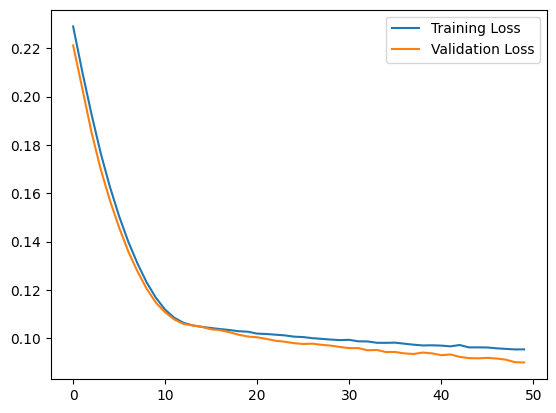

In [50]:
# Initialize Layer 1
anomaly_detector = AdaptiveNIDSLayer1(input_dim=X_train.shape[1], latent_dim=16)
history = anomaly_detector.train(X_train, X_val, epochs=50)

# Plot training history (optional)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [49]:
# Preprocess X_val for Layer 2
# Step 1: Detect anomalies in X_val (optional, depending on your use case)
X_val_anomalies, val_indices = anomaly_detector.detect_anomalies(X_val, threshold=0.02)
y_val_anomalies = y_val.iloc[val_indices].values  # Convert to NumPy array

# Ensure y_val_anomalies is integer type
y_val_anomalies = y_val_anomalies.astype(int)

# Step 2: Extract features for X_val
X_val_features = anomaly_detector.extract_features(X_val_anomalies)

# Step 3: Apply PCA to X_val
X_val_pca = pca.transform(X_val_features)  # Use the same PCA model saved earlier

# Load feature indices from file (assuming they were saved during training)
feature_indices = joblib.load('feature_indices.pkl')

# Step 4: Select features (optional, if you used feature selection earlier)
X_val_selected = X_val_pca[:, feature_indices]  # Use the same feature_indices saved earlier
# Load feature indices from file
feature_indices = joblib.load('feature_indices.pkl')
# Step 5: Create sequences for X_val
X_val_sequences, y_val_sequences = create_sequences(X_val_selected, y_val_anomalies, seq_length=seq_length)

# Initialize Layer 2
num_classes = len(np.unique(y_balanced))  # Ensure this matches your dataset
layer2_model = AdaptiveNIDSLayer2(
    input_dim=X_balanced.shape[2],  # Features per timestep
    num_classes=num_classes,
    seq_length=seq_length
)

# Train
history = layer2_model.train(
    X_balanced, 
    y_balanced, 
    X_val_sequences,  # Use preprocessed X_val
    y_val_sequences,  # Use preprocessed y_val
    epochs=50
)

# Plot training history
layer2_model.plot_training_history(history)

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step


FileNotFoundError: [Errno 2] No such file or directory: 'feature_indices.pkl'

Epoch 1/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.2327 - val_loss: 0.2190 - learning_rate: 1.0000e-04
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.2102 - val_loss: 0.2003 - learning_rate: 1.0000e-04
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1944 - val_loss: 0.1826 - learning_rate: 1.0000e-04
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1758 - val_loss: 0.1684 - learning_rate: 1.0000e-04
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1626 - val_loss: 0.1559 - learning_rate: 1.0000e-04
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1512 - val_loss: 0.1450 - learning_rate: 1.0000e-04
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1425 - val_loss: 0.1357 - learning_rate: 1.0000e-04
Epoch 8/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1340 - val_loss: 0.1275 - learning_rate: 1.0000e-04
Epoch 9/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1245 - val_loss: 

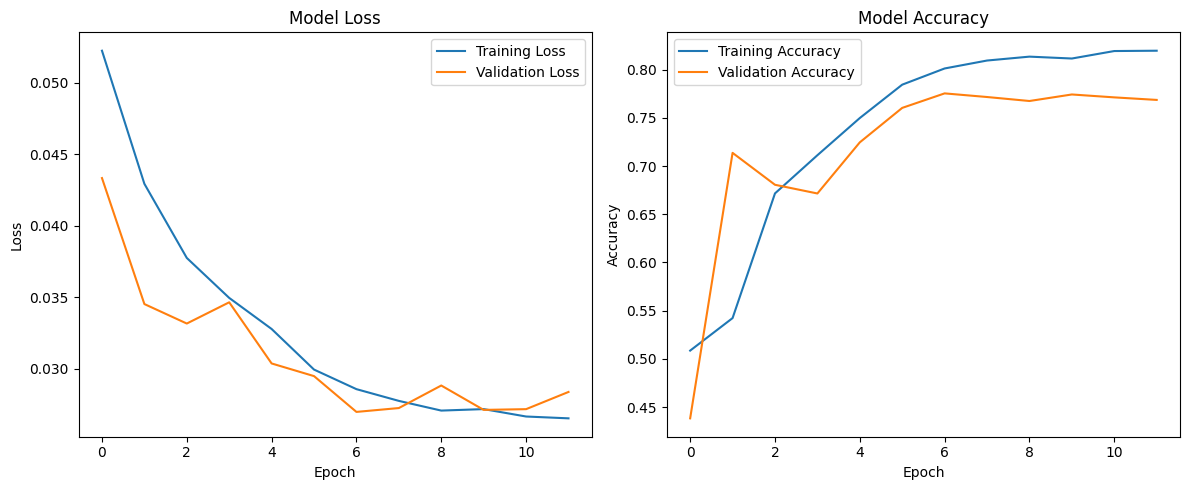

In [18]:
if __name__ == "__main__":
    main()

# Network Intrusion Detection System Training Report

## Model Architecture Overview
**Two-Layer System:**
1. **Layer 1 (Anomaly Detection):** Autoencoder with Conv1D + LSTM layers
2. **Layer 2 (Classification):** Bidirectional LSTM with Attention Mechanism

---

## Key Metrics & Observations

### **Layer 1 Performance (Autoencoder)**
| Metric              | Start Value | End Value | Improvement |
|---------------------|-------------|-----------|-------------|
| Training Loss       | 0.2327      | 0.0957    | 59% ↓       |
| Validation Loss     | 0.2190      | 0.0908    | 58% ↓       |
| Learning Rate       | 1e-4        | 5e-5      | Adjusted at Epoch 45 |

- Smooth convergence with no signs of overfitting
- Final validation loss: **0.0908**

---

### **Layer 2 Performance (Classification)**
#### Training Highlights:
- **Best Validation F1 Score:** 0.7848 (Epoch 7)
- Early Stopping Triggered at Epoch 12 (Patience=5)
- Final Metrics:
  - Validation Accuracy: **77.54%**
  - Weighted F1: **0.78**

#### Class-Wise Performance:
| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.58      | 0.89   | 0.70     | 791     |
| 1     | 0.94      | 0.73   | 0.82     | 1,867   |

**Key Insight:**  
- Class 0 (Minority) shows high recall (89%) but lower precision (58%)
- Class 1 (Majority) has excellent precision (94%) but moderate recall (73%)

---

### **Data Processing Pipeline**
1. **Anomaly Detection:**
   - Threshold: 0.02
   - Training Anomalies Detected: 10,610 samples (3199 normal + 7411 anomalous)
   - Validation Anomalies Detected: 2,658 samples

2. **Feature Engineering:**
   - PCA reduced features from 32 → 2 (99.63% variance retained)
   - SMOTE balanced class distribution: **[7411, 7411]**

3. **Sequencing:**
   - Sequence Length: 10 timesteps
   - Final Training Sequences: 464 batches
   - Validation Sequences: 84 batches

---

## Critical Analysis

### **Strengths**
- Effective anomaly detection with stable training (Layer 1)
- Successful class balancing using SMOTE (+48% minority class samples)
- Smooth learning rate scheduling (Cosine decay + warmup)
- Attention mechanism in Layer 2 improves feature focus

### **Weaknesses**
- **Feature Bottleneck:** PCA reduction to 2 features may oversimplify patterns
- **Class 1 Performance Gap:** High precision but suboptimal recall (73%)
- Early stopping at epoch 12 suggests limited post-epoch 7 improvements

---

## Recommendations
1. **Feature Engineering**
   - Retain more PCA components (e.g., 95% variance → 5-8 features)
   - Experiment with feature selection (`n_features > 2`)

2. **Model Optimization**
   - Increase LSTM units in Layer 2 (current: 32)
   - Test higher anomaly thresholds (e.g., 0.03-0.05)

3. **Validation**
   - Introduce separate test set for final evaluation
   - Use stratified sampling to preserve class ratios

4. **Advanced Techniques**
   - Replace SMOTE with ADASYN for synthetic sample generation
   - Add dropout regularization in Layer 2’s Conv1D blocks

---

## Conclusion
The system demonstrates strong anomaly detection capabilities but requires tuning for better classification performance. Prioritize feature retention and architecture adjustments to bridge the recall gap for Class 1 while maintaining high precision.